In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import scipy as sp
from scipy.optimize import minimize, Bounds

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


Bad key "text.kerning_factor" on line 4 in
/home/asuresh/programs/anaconda3/envs/DCTR/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(keras.__version__)  # 2.2.4

1.15.0
2.2.4


# The SRGN fitting algorithm

The DCTR paper ([arXiv:1907.08209](https://arxiv.org/abs/1907.08209)) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at generator-level (before detector simulation) while the fit happens in simulation (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at simulation-level or both happen at generator-level.  This notebook illustrates the alternative SRGN procedure from [arXiv:2010.03569](https://arxiv.org/abs/2010.03569):

Let $x$ and $y$ denote the generator- and simulation-level events respectively. Suppose that $g$ is a neural network defined as follows:

$g_{\theta'}(y)=\text{argmax}_{g}\sum_{y_i\in\boldsymbol{\theta_?}}\log(g_{\theta'}(y_i))+
    \sum_{(x_i,y_i)\in\boldsymbol{\theta_0}}w_{\theta_0}(x_i,\theta')\log(1-g_{\theta'}(y_i))$

where $w_{\theta_0}(x,\theta') = f(x,\theta')/(1-f(x,\theta'))$ is a reweighting function learned at generator level (and $\theta_0$ denotes the nominal value of the parameter).  

Then, 

$\theta_{\text{SRGN}}^*\equiv\text{argmin}_{\theta'}\left[\Pr(g_{\theta_?}(y)>g_{\theta'}(y))\right]$

where the quantity in $[\cdot]$ is typically called the area under the receiver operating characteristic curve or AUC. We calculate the AUC between $g$’s predictions on events from the unknown sample and  $g$’s predictions on reweighted events from the synthetic sample; effectively, if we reweight events from the synthetic sample $\boldsymbol{\theta_0}$ to events from $\boldsymbol{\theta’}$, then we calculate the AUC between $g$’s predictions on  $\boldsymbol{\theta_?} $and $g$’s predictions on $\boldsymbol{\theta’}$.


The intuition of the above equation is that the classifier $g$ is trying to distinguish events from the unknown sample $\boldsymbol{\theta_?}$ and events from $\boldsymbol{\theta'}$ and we try to find a $\theta'$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples (i.e. the AUC is minimized), then the reweighting has worked! Asympotitically, the SRGN method learns the same result as the one in the body of the DCTR paper: $\theta^*=\theta_?$.

# Top Quark Mass Extraction
In this notebook, we apply the SRGN fitting algorithm to fitting the mass of the top quark (denoted $M_t$). 

Four observables are formed for performing the top quark mass extraction.  First, the $b$-jet closest to the muon is labeled $b_1$.  Of the remaining $b$-tagged jets, the highest $p_T$ one is labeled $b_2$.  The highest two $p_T$ non $b$-tagged jets are labeled $j_1$ and $j_2$.  The four observables are given by: $m_{b_1\mu\nu}, m_{b_2j_1j_2}, m_{b_2\mu\nu}$, and $m_{b_1j_1j_2}$, where the four-momentum of the detector-level neutrino is determined by solving the quadratic equation for the $W$ boson mass. We denote: ${\mathcal{O}}_4 = \{m_{b_1\mu\nu}, m_{b_2\mu\nu}, m_{b_2j_1j_2}, m_{b_1j_1j_2}\}$.

In [5]:
data_dir = '/data1/users/asuresh/DCTRFitting/TopQuarkFitting/'

### Utilities

In [6]:
def preprocess_data(X):
    return X / 1000.

## Training a DCTR Model
First, we need to train a DCTR model parameterized by $M_t$ to provide us with a reweighting function to be used during fitting.

### Load training & validation data

In [7]:
dataset = np.load(data_dir + 'DCTR_Mt_train.npz')

X = dataset['X']
Y = dataset['Y']

X = preprocess_data(X)
Y = to_categorical(Y)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

### Build Model

In [8]:
inputs = Input((5, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr = Model(inputs=inputs, outputs=outputs)
dctr.compile(loss='categorical_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

### Train Model

In [9]:
earlystopping = EarlyStopping(patience=20,
                              verbose=1,
                              restore_best_weights=True)

dctr.fit(X_train,
         Y_train,
         epochs=200,
         batch_size=1000,
         validation_data=(X_val, Y_val),
         verbose=1,
         callbacks=[earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5548419 samples, validate on 1387105 samples
Epoch 1/200





5548419/5548419 [==============================] - 32s 6us/step - loss: 0.5109 - acc: 0.7925 - val_loss: 0.5115 - val_acc: 0.7924
Epoch 2/200
5548419/5548419 [==============================] - 31s 6us/step - loss: 0.5103 - acc: 0.7925 - val_loss: 0.5103 - val_acc: 0.7924
Epoch 3/200
5548419/5548419 [==============================] - 31s 6us/step - loss: 0.5100 - acc: 0.7925 - val_loss: 0.5098 - val_acc: 0.7924
Epoch 4/200
5548419/5548419 [==============================] - 31s 6us/step - loss: 0.5096 - acc: 0.7925 - val_loss: 0.5094 - val_acc: 0.7924
Epoch 5/200
5548419/5548419 [==============================] - 31s 6us/step - loss: 0.5091 - acc: 0.7925 - val_loss: 0.5088 - val_acc: 0.7924
Epoch 6/200
5548419/5548419 [==============================] - 31s 6us/step - loss: 0.5088 - acc: 0.7925 - val_loss: 0.5087 - val_acc:

### Defining reweighting function

$w_{\theta_0}(x_{G,i},\theta)=\frac{f(x_{G,i},\theta)}{1-f(x_{G,i},\theta)}$, where $f$  is a fully trained DCTR model.

Takes generator-level event $x_{G,i}$ from the synthetic sample $\boldsymbol{\theta_0}$ and weights it to an event from $\boldsymbol{\theta}$.

In [10]:
def reweight(events, param):
    theta_prime = param / 1000

    # creating array with same length as inputs, with theta_prime in every entry
    concat_input_and_params = np.ones(shape=(events.shape[0], 1)) * theta_prime
    # combining and reshaping into correct format:
    model_inputs = np.concatenate((events, concat_input_and_params), axis=-1)

    f = dctr.predict(model_inputs, batch_size=1000)

    weights = (f[:, 1]) / (f[:, 0])
    return weights

## Validate DCTR for $M_t=175\text{ GeV}$

In [11]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}
plot_style_1 = {'alpha': 0.5, 'density': True}

label_0 = r'$M_t=172.5$'

label_1 = r'$M_t=175.0$'

pythia_text = r'\textsc{Pythia 8 + Delphes 3}' + '\n' + r'$pp \to t\bar{t}$' + '\n' + r"anti-$k_{\mathrm{T}}$, $R=0.4$"


def make_legend(ax, loc='best'):
    leg = ax.legend(frameon=False, loc=loc)
    leg.set_title(pythia_text, prop={'size': 14})
    leg._legend_box.align = "left"

In [12]:
test_dataset_0 = np.load(data_dir + 'SRGN_Mt_default.npz')
test_dataset_1 = np.load(data_dir + 'SRGN_Mt_unknown.npz')

X0_test_G = preprocess_data(test_dataset_0['generator'])
X0_test_S = preprocess_data(test_dataset_0['simulation'])
X1_test_G = preprocess_data(test_dataset_1['generator'])
X1_test_S = preprocess_data(test_dataset_1['simulation'])

In [13]:
weights = reweight(X0_test_G, 175.)

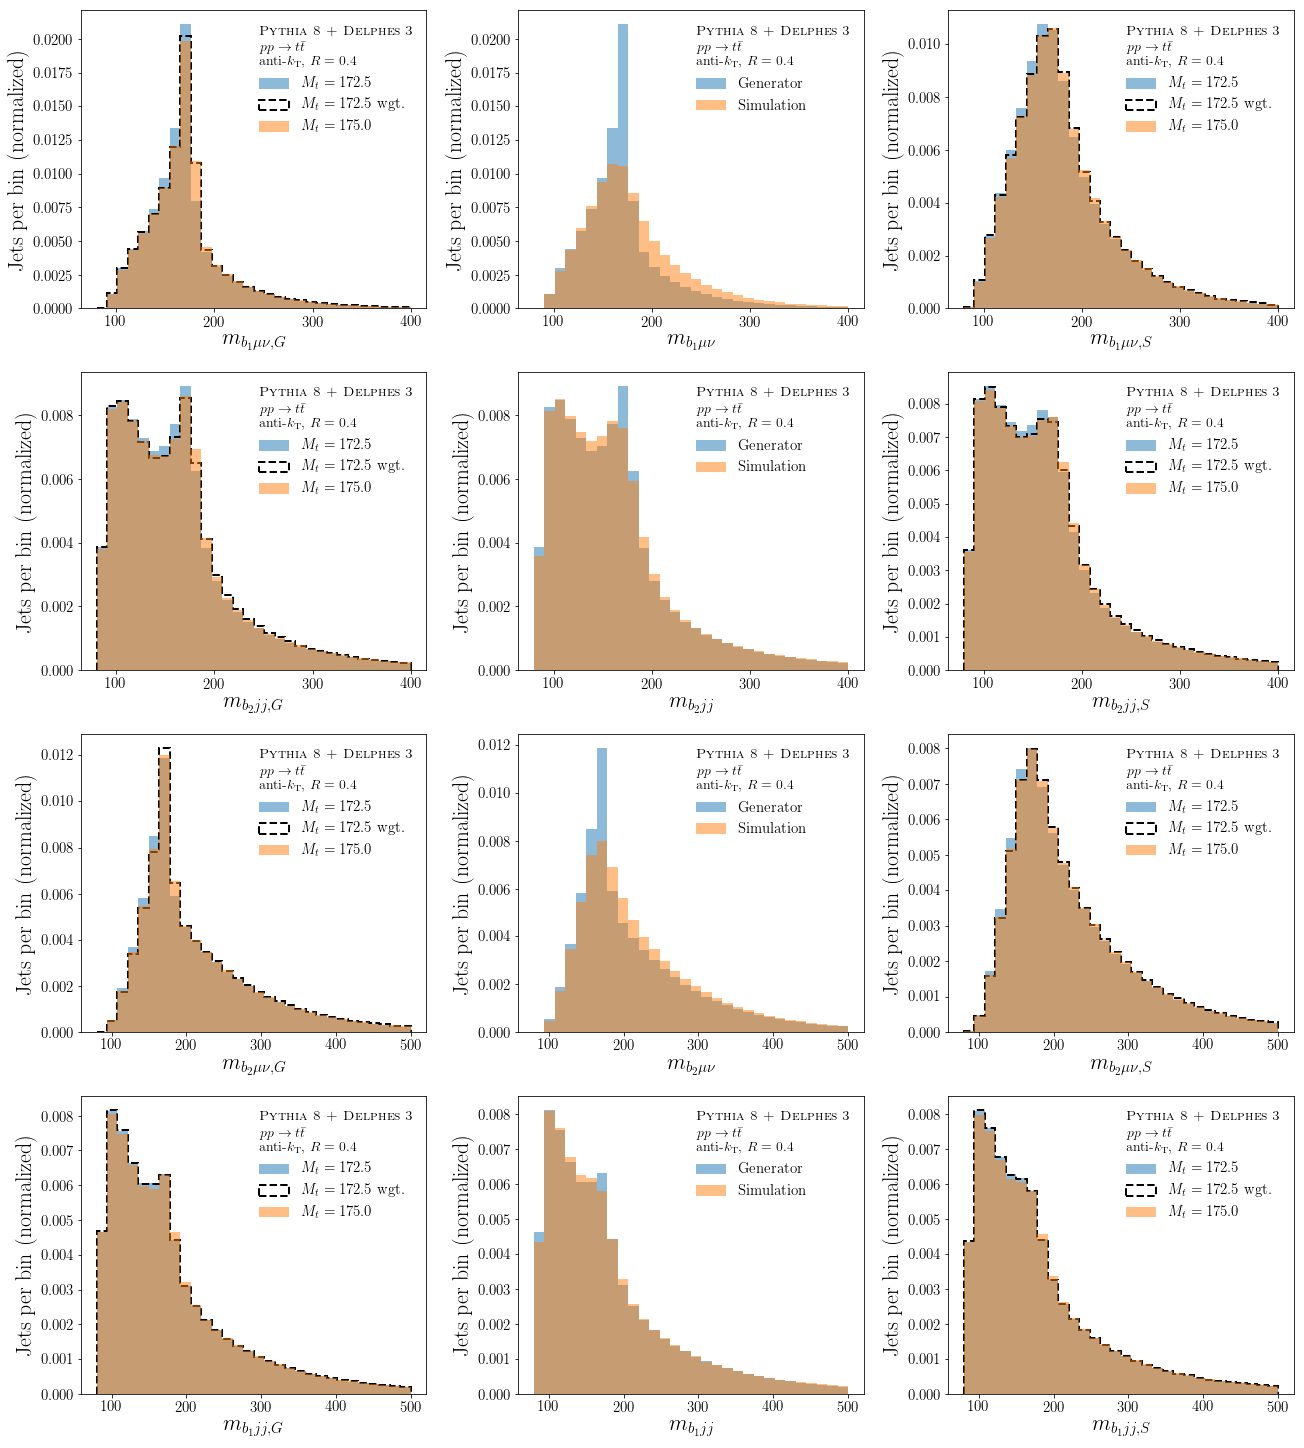

In [14]:
fig, ax = plt.subplots(4, 3, figsize=(18, 20), constrained_layout=True)

bins = np.linspace(80, 400, 31)
ax[0, 0].hist(1000 * X0_test_G[:, 0], bins=bins, label=label_0, **plot_style_1)
ax[0, 0].hist(1000 * X0_test_G[:, 0],
              weights=weights,
              bins=bins,
              label=label_0 + ' wgt.',
              **plot_style_0)
ax[0, 0].hist(1000 * X1_test_G[:, 0], bins=bins, label=label_1, **plot_style_1)
ax[0, 0].set_xlabel(r'$m_{b_1\mu\nu, G}$')
ax[0, 0].set_ylabel('Jets per bin (normalized)')
make_legend(ax[0, 0])

bins = np.linspace(80, 400, 31)
ax[1, 0].hist(1000 * X0_test_G[:, 1], bins=bins, label=label_0, **plot_style_1)
ax[1, 0].hist(1000 * X0_test_G[:, 1],
              weights=weights,
              bins=bins,
              label=label_0 + ' wgt.',
              **plot_style_0)
ax[1, 0].hist(1000 * X1_test_G[:, 1], bins=bins, label=label_1, **plot_style_1)
ax[1, 0].set_xlabel(r'$m_{b_2jj, G}$')
ax[1, 0].set_ylabel('Jets per bin (normalized)')
make_legend(ax[1, 0])

bins = np.linspace(80, 500, 31)
ax[2, 0].hist(1000 * X0_test_G[:, 2], bins=bins, label=label_0, **plot_style_1)
ax[2, 0].hist(1000 * X0_test_G[:, 2],
              weights=weights,
              bins=bins,
              label=label_0 + ' wgt.',
              **plot_style_0)
ax[2, 0].hist(1000 * X1_test_G[:, 2], bins=bins, label=label_1, **plot_style_1)
ax[2, 0].set_xlabel(r'$m_{b_2\mu\nu, G}$')
ax[2, 0].set_ylabel('Jets per bin (normalized)')
make_legend(ax[2, 0])

bins = np.linspace(80, 500, 31)
ax[3, 0].hist(1000 * X0_test_G[:, 3], bins=bins, label=label_0, **plot_style_1)
ax[3, 0].hist(1000 * X0_test_G[:, 3],
              weights=weights,
              bins=bins,
              label=label_0 + ' wgt.',
              **plot_style_0)
ax[3, 0].hist(1000 * X1_test_G[:, 3], bins=bins, label=label_1, **plot_style_1)
ax[3, 0].set_xlabel(r'$m_{b_1jj, G}$')
ax[3, 0].set_ylabel('Jets per bin (normalized)')
make_legend(ax[3, 0])

bins = np.linspace(80, 400, 31)
ax[0, 1].hist(1000 * X0_test_G[:, 0],
              bins=bins,
              label='Generator',
              **plot_style_1)

ax[0, 1].hist(1000 * X0_test_S[:, 0],
              bins=bins,
              label='Simulation',
              **plot_style_1)
ax[0, 1].set_xlabel(r'$m_{b_1\mu\nu}$')
ax[0, 1].set_ylabel('Jets per bin (normalized)')
make_legend(ax[0, 1])

bins = np.linspace(80, 400, 31)
ax[1, 1].hist(1000 * X0_test_G[:, 1],
              bins=bins,
              label='Generator',
              **plot_style_1)

ax[1, 1].hist(1000 * X0_test_S[:, 1],
              bins=bins,
              label='Simulation',
              **plot_style_1)
ax[1, 1].set_xlabel(r'$m_{b_2jj}$')
ax[1, 1].set_ylabel('Jets per bin (normalized)')
make_legend(ax[1, 1])

bins = np.linspace(80, 500, 31)
ax[2, 1].hist(1000 * X0_test_G[:, 2],
              bins=bins,
              label='Generator',
              **plot_style_1)

ax[2, 1].hist(1000 * X0_test_S[:, 2],
              bins=bins,
              label='Simulation',
              **plot_style_1)
ax[2, 1].set_xlabel(r'$m_{b_2\mu\nu}$')
ax[2, 1].set_ylabel('Jets per bin (normalized)')
make_legend(ax[2, 1])

bins = np.linspace(80, 500, 31)
ax[3, 1].hist(1000 * X0_test_G[:, 3],
              bins=bins,
              label='Generator',
              **plot_style_1)

ax[3, 1].hist(1000 * X0_test_S[:, 3],
              bins=bins,
              label='Simulation',
              **plot_style_1)
ax[3, 1].set_xlabel(r'$m_{b_1jj}$')
ax[3, 1].set_ylabel('Jets per bin (normalized)')
make_legend(ax[3, 1])

bins = np.linspace(80, 400, 31)
ax[0, 2].hist(1000 * X0_test_S[:, 0], bins=bins, label=label_0, **plot_style_1)
ax[0, 2].hist(1000 * X0_test_S[:, 0],
              weights=weights,
              bins=bins,
              label=label_0 + ' wgt.',
              **plot_style_0)
ax[0, 2].hist(1000 * X1_test_S[:, 0], bins=bins, label=label_1, **plot_style_1)
ax[0, 2].set_xlabel(r'$m_{b_1\mu\nu, S}$')
ax[0, 2].set_ylabel('Jets per bin (normalized)')
make_legend(ax[0, 2])

bins = np.linspace(80, 400, 31)
ax[1, 2].hist(1000 * X0_test_S[:, 1], bins=bins, label=label_0, **plot_style_1)
ax[1, 2].hist(1000 * X0_test_S[:, 1],
              weights=weights,
              bins=bins,
              label=label_0 + ' wgt.',
              **plot_style_0)
ax[1, 2].hist(1000 * X1_test_S[:, 1], bins=bins, label=label_1, **plot_style_1)
ax[1, 2].set_xlabel(r'$m_{b_2jj, S}$')
ax[1, 2].set_ylabel('Jets per bin (normalized)')
make_legend(ax[1, 2])

bins = np.linspace(80, 500, 31)
ax[2, 2].hist(1000 * X0_test_S[:, 2], bins=bins, label=label_0, **plot_style_1)
ax[2, 2].hist(1000 * X0_test_S[:, 2],
              weights=weights,
              bins=bins,
              label=label_0 + ' wgt.',
              **plot_style_0)
ax[2, 2].hist(1000 * X1_test_S[:, 2], bins=bins, label=label_1, **plot_style_1)
ax[2, 2].set_xlabel(r'$m_{b_2\mu\nu, S}$')
ax[2, 2].set_ylabel('Jets per bin (normalized)')
make_legend(ax[2, 2])

bins = np.linspace(80, 500, 31)
ax[3, 2].hist(
    1000 * X0_test_S[:, 3],
    bins=bins,
    label=label_0,
    **plot_style_1,
)
ax[3, 2].hist(1000 * X0_test_S[:, 3],
              weights=weights,
              bins=bins,
              label=label_0 + ' wgt.',
              **plot_style_0)
ax[3, 2].hist(1000 * X1_test_S[:, 3], bins=bins, label=label_1, **plot_style_1)
ax[3, 2].set_xlabel(r'$m_{b_1jj, S}$')
ax[3, 2].set_ylabel('Jets per bin (normalized)')
make_legend(ax[3, 2])

fig.show()

# Fitting

## Setup the dataset

$\boldsymbol{\theta_0}$ denotes the synthetic sample used for reweighting, and we are trying to fit the parameter $\theta$ (in this case $M_t$) to the 'data' sample $\boldsymbol{\theta_?}$ (`theta_unknown`).

In [15]:
theta0_G = X0_test_G
theta0_S = X0_test_S
theta_unknown_G = X1_test_G
theta_unknown_S = X1_test_S

labels0 = np.zeros_like(theta0_G[:, 0])
labels_unknown = np.ones_like(theta_unknown_G[:, 0])

In [16]:
xvals_G = np.concatenate((theta0_G, theta_unknown_G), axis=0)
xvals_S = np.concatenate((theta0_S, theta_unknown_S), axis=0)

yvals = np.concatenate((labels0, labels_unknown), axis=0)

In [17]:
X_train_G, X_test_G, X_train_S, X_test_S, Y_train, Y_test = train_test_split(
    xvals_G, xvals_S, yvals, test_size=0.5)

## Fitting Model: Scan (with Four Observables)

We will show for fixed $\theta$, the AUC is minimized when $\theta=\theta_?$.

### Creating Model

In [18]:
myinputs = Input(shape=(4, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()

batch_size = 1000
earlystopping = EarlyStopping(patience=20, restore_best_weights=True)

# scanning range for theta
thetas = np.linspace(170., 180., 9)

weights_initialize = model.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________


We will train this model with a weighted binary cross-entropy loss function:

$\text{loss}(g_{\theta'}(x))=-\sum_{x_i\in\boldsymbol{\theta_?}}\log(g_{\theta'}(x_i))-
    \sum_{x_i\in\boldsymbol{\theta_0}}w_{\theta_0}(x_{G,i},\theta')\log(1-g_{\theta'}(x_i))$
    
where $x_i=x_{G,i}$ when fitting on generator-level and $x_i=x_{S,i}$ when fitting on simulation-level. Note that reweighting always occurs on generator-level, as we always know the generator-level events for the synthetic sample (but not necessarily for the data).

### Generator-level Scan

Here, we actually know the generator-level events for both the synthetic sample and data.

In [19]:
def run_classifier_G(theta):

    weights_train = np.ones(len(X_train_G))
    weights_test = np.ones(len(X_test_G))

    # calculate weights for events in theta_0, but leave ones for events in theta_?
    weights_train[Y_train == 0] = reweight(X_train_G[Y_train == 0], theta)
    weights_test[Y_test == 0] = reweight(X_test_G[Y_test == 0], theta)
    
    # reinitialize model weights
    model.set_weights(weights_initialize)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # fit model on weighted binary cross-entropy
    history = model.fit(X_train_G,
                        Y_train,
                        sample_weight=weights_train,
                        epochs=200,
                        batch_size=batch_size,
                        validation_data=(X_test_G, Y_test, weights_test),
                        verbose=0,
                        callbacks=[earlystopping])

    # after training, calculate AUC between unknown sample and reweighted synthetic sample
    auc = roc_auc_score(np.concatenate((Y_train, Y_test)),
                        model.predict(np.concatenate((X_train_G, X_test_G)),
                                      batch_size=batch_size),
                        sample_weight=np.concatenate(
                            (weights_train, weights_test)))

    return auc

In [20]:
AUC_G = []

for theta in thetas:
    print("Testing theta = {:.2f}".format(theta))

    auc = run_classifier_G(theta)
    AUC_G += [auc]

    print("AUC: {:.3f}".format(auc))
    print("\n")
    pass

Testing theta = 170.00
AUC: 0.575


Testing theta = 171.25
AUC: 0.569


Testing theta = 172.50
AUC: 0.554


Testing theta = 173.75
AUC: 0.528


Testing theta = 175.00
AUC: 0.506


Testing theta = 176.25
AUC: 0.525


Testing theta = 177.50
AUC: 0.543


Testing theta = 178.75
AUC: 0.560


Testing theta = 180.00
AUC: 0.576




### Simulation-level Scan
Here, we only know the generator-level events for the synthetic sample and the simulation-level events for both samples. Thus, we reweight on the generator-level events, but classify between the simulation-level events.

In [21]:
def run_classifier_S(theta):

    weights_train = np.ones(len(X_train_G))
    weights_test = np.ones(len(X_test_G))

    # calculate weights for events in theta_0, but leave ones for events in theta_?
    weights_train[Y_train == 0] = reweight(X_train_G[Y_train == 0], theta)
    weights_test[Y_test == 0] = reweight(X_test_G[Y_test == 0], theta)

    # reinitialize model weights
    model.set_weights(weights_initialize)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # fit model on weighted binary cross-entropy
    history = model.fit(X_train_S,
                        Y_train,
                        sample_weight=weights_train,
                        epochs=200,
                        batch_size=batch_size,
                        validation_data=(X_test_S, Y_test, weights_test),
                        verbose=0,
                        callbacks=[earlystopping])

    # after training, calculate AUC between unknown sample and reweighted synthetic sample
    auc = roc_auc_score(np.concatenate((Y_train, Y_test)),
                        model.predict(np.concatenate((X_train_S, X_test_S)),
                                      batch_size=batch_size),
                        sample_weight=np.concatenate(
                            (weights_train, weights_test)))

    return auc

In [22]:
AUC_S = []

for theta in thetas:
    print("Testing theta = {:.2f}".format(theta))

    auc = run_classifier_S(theta)
    AUC_S += [auc]

    print("AUC: {:.3f}".format(auc))
    print("\n")
    pass

Testing theta = 170.00
AUC: 0.529


Testing theta = 171.25
AUC: 0.525


Testing theta = 172.50
AUC: 0.518


Testing theta = 173.75
AUC: 0.509


Testing theta = 175.00
AUC: 0.506


Testing theta = 176.25
AUC: 0.509


Testing theta = 177.50
AUC: 0.515


Testing theta = 178.75
AUC: 0.520


Testing theta = 180.00
AUC: 0.527




### Scan results

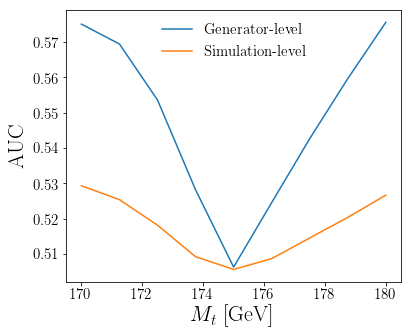

In [23]:
plt.figure(figsize=(6, 5))
plt.plot(thetas, AUC_G, label='Generator-level')
plt.plot(thetas, AUC_S, label='Simulation-level')
plt.xlabel(r"$M_t$ [GeV]")
plt.ylabel('AUC')
plt.legend(frameon=False)
plt.show()

## Comparison to Fitting on $m_{b_1\mu\nu}$ only

Let's compare fitting on all four observables to fitting only on the reconstructed leptonic mass.  

In [24]:
K.clear_session()

### Training a DCTR Model
First, we need to train a DCTR model parameterized by $M_t$ that only receives $m_{b_1\mu\nu}$ as an input to provide us with a reweighting function to be used during fitting.

#### Generate training & validation data

In [25]:
X = dataset['X']
Y = dataset['Y']

# only include m_{b1,mu,nu} and its paired M_t
X = preprocess_data(X[:, 0:5:4])
Y = to_categorical(Y)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

#### Build Model

In [26]:
inputs = Input((2, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr = Model(inputs=inputs, outputs=outputs)
dctr.compile(loss='categorical_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

#### Train Model

In [27]:
earlystopping = EarlyStopping(patience=20,
                              verbose=1,
                              restore_best_weights=True)

dctr.fit(X_train,
         Y_train,
         epochs=200,
         batch_size=1000,
         validation_data=(X_val, Y_val),
         verbose=1,
         callbacks=[earlystopping])

Train on 5548419 samples, validate on 1387105 samples
Epoch 1/200
5548419/5548419 [==============================] - 32s 6us/step - loss: 0.5111 - acc: 0.7925 - val_loss: 0.5110 - val_acc: 0.7920
Epoch 2/200
5548419/5548419 [==============================] - 31s 6us/step - loss: 0.5101 - acc: 0.7926 - val_loss: 0.5108 - val_acc: 0.7920
Epoch 3/200
5548419/5548419 [==============================] - 31s 6us/step - loss: 0.5096 - acc: 0.7926 - val_loss: 0.5102 - val_acc: 0.7920
Epoch 4/200
5548419/5548419 [==============================] - 31s 6us/step - loss: 0.5089 - acc: 0.7926 - val_loss: 0.5090 - val_acc: 0.7920
Epoch 5/200
5548419/5548419 [==============================] - 31s 6us/step - loss: 0.5084 - acc: 0.7926 - val_loss: 0.5101 - val_acc: 0.7920
Epoch 6/200
5548419/5548419 [==============================] - 31s 6us/step - loss: 0.5081 - acc: 0.7926 - val_loss: 0.5090 - val_acc: 0.7920
Epoch 7/200
5548419/5548419 [==============================] - 31s 6us/step - loss: 0.5081 - a

### Fitting

#### Setup the Dataset

In [28]:
theta0_G = X0_test_G[:, 0:1]
theta0_S = X0_test_S[:, 0:1]
theta_unknown_G = X1_test_G[:, 0:1]
theta_unknown_S = X1_test_S[:, 0:1]

labels0 = np.zeros_like(theta0_G[:, 0])
labels_unknown = np.ones_like(theta_unknown_G[:, 0])

In [29]:
xvals_G = np.concatenate((theta0_G, theta_unknown_G), axis=0)
xvals_S = np.concatenate((theta0_S, theta_unknown_S), axis=0)

yvals = np.concatenate((labels0, labels_unknown), axis=0)

In [30]:
X_train_G, X_test_G, X_train_S, X_test_S, Y_train, Y_test = train_test_split(
    xvals_G, xvals_S, yvals, test_size=0.5)

#### Fitting Model: Scan (with $m_{b_1\mu\nu}$ only)

In [31]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()

batch_size = 1000
earlystopping = EarlyStopping(patience=20, restore_best_weights=True)

weights_initialize = model.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


Again, we will train this model with a weighted binary cross-entropy loss function:

$\text{loss}(g_{\theta'}(x))=-\sum_{x_i\in\boldsymbol{\theta_?}}\log(g_{\theta'}(x_i))-
    \sum_{x_i\in\boldsymbol{\theta_0}}w_{\theta_0}(x_{G,i},\theta')\log(1-g_{\theta'}(x_i))$

##### Generator-level Scan

Here, we actually know the generator-level events for both the synthetic sample and data.

In [32]:
AUC_m_b1_mu_nu_G = []

for theta in thetas:
    print("Testing theta = {:.2f}".format(theta))

    auc = run_classifier_G(theta)
    AUC_m_b1_mu_nu_G += [auc]

    print("AUC: {:.3f}".format(auc))
    print("\n")
    pass

Testing theta = 170.00
AUC: 0.568


Testing theta = 171.25
AUC: 0.558


Testing theta = 172.50
AUC: 0.542


Testing theta = 173.75
AUC: 0.522


Testing theta = 175.00
AUC: 0.506


Testing theta = 176.25
AUC: 0.518


Testing theta = 177.50
AUC: 0.539


Testing theta = 178.75
AUC: 0.553


Testing theta = 180.00
AUC: 0.565




##### Simulation-level Scan
Here, we only know the generator-level events for the synthetic sample and the simulation-level events for both samples. Thus, we reweight on the generator-level events, but classify between the simulation-level events.

In [33]:
AUC_m_b1_mu_nu_S = []

for theta in thetas:
    print("Testing theta = {:.2f}".format(theta))

    auc = run_classifier_S(theta)
    AUC_m_b1_mu_nu_S += [auc]

    print("AUC: {:.3f}".format(auc))
    print("\n")
    pass

Testing theta = 170.00
AUC: 0.521


Testing theta = 171.25
AUC: 0.517


Testing theta = 172.50
AUC: 0.512


Testing theta = 173.75
AUC: 0.507


Testing theta = 175.00
AUC: 0.503


Testing theta = 176.25
AUC: 0.505


Testing theta = 177.50
AUC: 0.511


Testing theta = 178.75
AUC: 0.515


Testing theta = 180.00
AUC: 0.520




### Scan Results

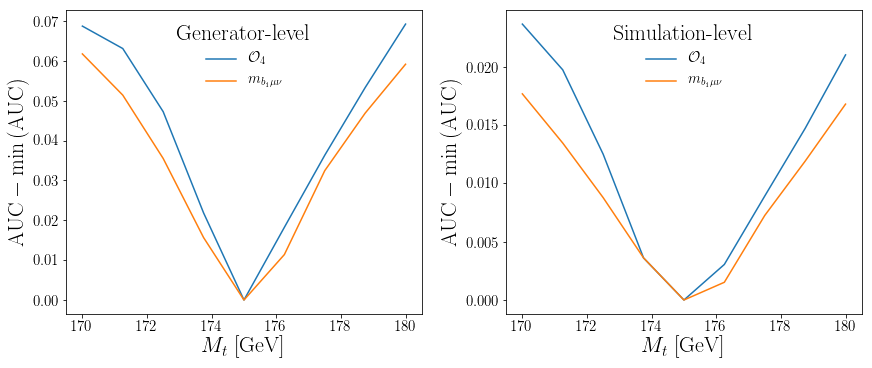

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

ax[0].plot(thetas, AUC_G - min(AUC_G), label='$\mathcal{O}_4$')

ax[0].plot(thetas,
           AUC_m_b1_mu_nu_G - min(AUC_m_b1_mu_nu_G),
           label=r'$m_{b_1\mu\nu}$')

ax[0].set_xlabel(r"$M_t$ [GeV]")
ax[0].set_ylabel(r"$\textnormal{AUC} - \min{(\textnormal{AUC})}$")
legend = ax[0].legend(title=r'Generator-level', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].plot(thetas, AUC_S - min(AUC_S), label='$\mathcal{O}_4$')

ax[1].plot(thetas,
           AUC_m_b1_mu_nu_S - min(AUC_m_b1_mu_nu_S),
           label=r'$m_{b_1\mu\nu}$')

ax[1].set_xlabel(r"$M_t$ [GeV]")
ax[1].set_ylabel(r"$\textnormal{AUC} - \min{(\textnormal{AUC})}$")
legend = ax[1].legend(title=r'Simulation-level', frameon=False)
plt.setp(legend.get_title(), multialignment='center')
fig.show()

Even when scanning only on $m_{b_1\mu\nu}$, a one dimensional feature, we've shown for fixed $\theta$, the AUC is minimized at $\theta=\theta_?$ for both generator- and simulation-level. However, the rise in the AUC function away from the minimum is steeper when scanning with all four observables than when scanning with only with the reconstructed hadronic mass, as expected given the increase in statistical power offered by all four observables. For both fits, also note the rise in the AUC function away from the minimum is steeper at generator-level than simulation-level, as expected given the loss of statistical power from detector smearing